In [2]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from ast import literal_eval
from tqdm import tqdm

from nltk.tokenize import sent_tokenize

In [3]:
DATA_PATH = os.path.join(
    "..", "..", "..", "..", "data", "frameworks_data", "per_proj_data"
)


def flatten(t):
    """
    flatten a list of lists.
    """
    return [item for sublist in t for item in sublist]


turkey_df = (
    pd.read_csv(os.path.join(DATA_PATH, "2021_ifrc_turkey_v0.1.1.csv"))
    .drop(
        columns=[
            "entry_type",
            "created_by_id",
            "lead_id",
            "modified_by_id",
            "project_id",
            "title",
            "id_entry",
            "response type",
            "analysis_framework_id",
            "additional_text",
            "modified_at",
        ]
    )
    .drop_duplicates()
    .rename(columns={"id": "entry_id"})
    .dropna()
).rename(
    columns={
        "1dpillars": "pillars_1d",
        "1dsubpillars": "subpillars_1d",
        "2dpillars": "pillars_2d",
        "2dsubpillars": "subpillars_2d",
    }
)

turkey_df["created_at"] = pd.to_datetime(turkey_df.created_at).apply(lambda x: x.date)
geo_mapping_df = pd.read_csv(os.path.join(DATA_PATH, "geoarea_v0.1.csv")).rename(
    columns={"id": "area_id"}
)
turkey_df["geolocation"] = turkey_df["geolocation"].apply(
    lambda x: list(set(literal_eval(x)))
)


In [4]:
turkey_proj_locations = geo_mapping_df[geo_mapping_df['area_id'].isin(list(set(flatten(turkey_df['geolocation']))))]

geo_mapper_dict = {x['area_id']: x['title'] for _, x in turkey_proj_locations.iterrows()}
mappable_ids = list(geo_mapper_dict.keys())

In [5]:
len(mappable_ids)

393

In [6]:
turkey_df['geolocation'] = turkey_df['geolocation'].apply(
    lambda x: [geo_mapper_dict[item] for item in x if item in mappable_ids]
)
turkey_df.head(2)

,entry_id,created_at,excerpt,sectors,subsectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,geolocation,specific needs groups,demographic groups,affected groups,reliability,severity,subsectors_negative
0,574620,2022-05-05,The Afghan diaspora in Turkey live in fear: xe...,[],[],[],[],['Displacement'],['Displacement->Social Cohesion'],[TURKEY],[],[],"['Affected', 'Displaced', 'Refugees (internati...",[],[],False
1,574621,2022-05-05,Turkey has been hosting one of the world's lar...,[],[],[],[],['Displacement'],['Displacement->Social Cohesion'],[TURKEY],[],[],"['Affected', 'Migrants']",[],[],False


In [7]:
turkey_df.created_at.value_counts()

2022-03-25    309
2020-04-14    272
2022-04-12    216
2022-02-02    202
2022-05-25    195
             ... 
2022-03-14      2
2021-02-10      2
2020-09-09      2
2020-11-25      1
2020-05-01      1
Name: created_at, Length: 450, dtype: int64

(array([18140., 18262., 18383., 18506., 18628., 18748., 18871., 18993.,
        19113., 19236.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

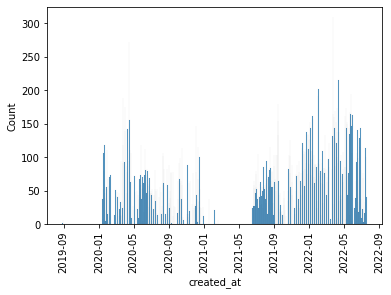

In [8]:
sns.histplot(turkey_df.created_at, )
plt.xticks(rotation=90)

In [9]:
from datetime import date, timedelta

today = date.today()

def allsundays(year):
    days_list = []
    d = date(year, 4, 1)                    # January 1st
    d += timedelta(days = 6 - d.weekday())  # First Sunday
    while d < today:
        d += timedelta(days = 7)
        days_list.append(d)
    return days_list[:-1]

days = allsundays(2022)

In [10]:
def custom_eval(x):
    if str(x)=='nan':
        return []
    if str(x)=='[None]':
        return []
    if type(x)==list:
        return x
    else:
        return literal_eval(x)

def get_props(column):
    clean_col = flatten([list(set(item)) for item in column.apply(custom_eval)])
    props = {name: 100 * counts / len(column) for name, counts in dict(Counter(clean_col)).items()}
    return props

sectors = []
subpillars_1d = []
subpillars_2d = []
demographic_groups = []	
affected_groups = []
geo_locations = []

for i in tqdm(range (len(days) - 1)):
    start_date = days[i]
    end_date = days[i + 1]
    one_week_df = turkey_df[turkey_df.created_at.apply(lambda x: x>=start_date and x<end_date)]

    sectors.append(get_props(one_week_df.sectors))
    subpillars_1d.append(get_props(one_week_df['pillars_1d']))
    subpillars_2d.append(get_props(one_week_df['pillars_2d']))
    demographic_groups.append(get_props(one_week_df['demographic groups']))
    affected_groups.append(get_props(one_week_df['affected groups']))
    geo_locations.append(get_props(one_week_df['geolocation']))

df_dates = [f'{days[i]}->{days[i+1]}'.replace('2022-', '') for i in range (len(days) - 1)]

100%|██████████| 14/14 [00:00<00:00, 18.49it/s]


In [14]:
df_dates

['04-10->04-17',
 '04-17->04-24',
 '04-24->05-01',
 '05-01->05-08',
 '05-08->05-15',
 '05-15->05-22',
 '05-22->05-29',
 '05-29->06-05',
 '06-05->06-12',
 '06-12->06-19',
 '06-19->06-26',
 '06-26->07-03',
 '07-03->07-10',
 '07-10->07-17']

In [15]:
df_sectors = pd.DataFrame(sectors).fillna(0)
df_sectors['dates'] = df_dates
df_sectors

,Food Security,Logistics,Livelihoods,Cross,Agriculture,Protection,Shelter,Education,Health,WASH,Nutrition,dates
0,2.249489,0.817996,10.838446,4.907975,0.408998,38.036810,3.476483,2.658487,2.862986,0.000000,0.000000,04-10->04-17
1,2.492212,1.246106,19.314642,9.968847,0.000000,45.482866,7.165109,5.295950,4.361371,0.623053,0.000000,04-17->04-24
2,1.000000,1.500000,9.250000,8.250000,0.000000,36.250000,3.250000,3.250000,13.500000,0.500000,0.000000,04-24->05-01
3,1.506024,1.506024,17.771084,3.915663,2.108434,41.867470,6.024096,1.807229,4.518072,0.903614,0.000000,05-01->05-08
4,4.166667,1.041667,25.892857,5.059524,0.148810,26.934524,4.315476,5.208333,5.357143,1.041667,0.148810,05-08->05-15
5,6.175299,0.597610,25.896414,7.968127,0.398406,36.653386,3.187251,10.557769,6.374502,0.796813,0.597610,05-15->05-22
6,2.941176,1.176471,20.235294,11.294118,0.588235,38.823529,4.117647,7.882353,8.352941,0.823529,0.000000,05-22->05-29
7,1.090909,0.727273,28.727273,14.545455,0.363636,31.272727,3.636364,12.000000,13.090909,0.727273,0.000000,05-29->06-05
8,18.181818,0.000000,20.454545,4.545455,1.136364,32.954545,12.500000,9.090909,3.409091,1.136364,3.409091,06-05->06-12
9,2.424242,2.020202,26.464646,15.151515,0.202020,34.343434,4.242424,7.070707,9.292929,1.414141,0.000000,06-12->06-19


Text(0.5, 0, 'Period Treated')

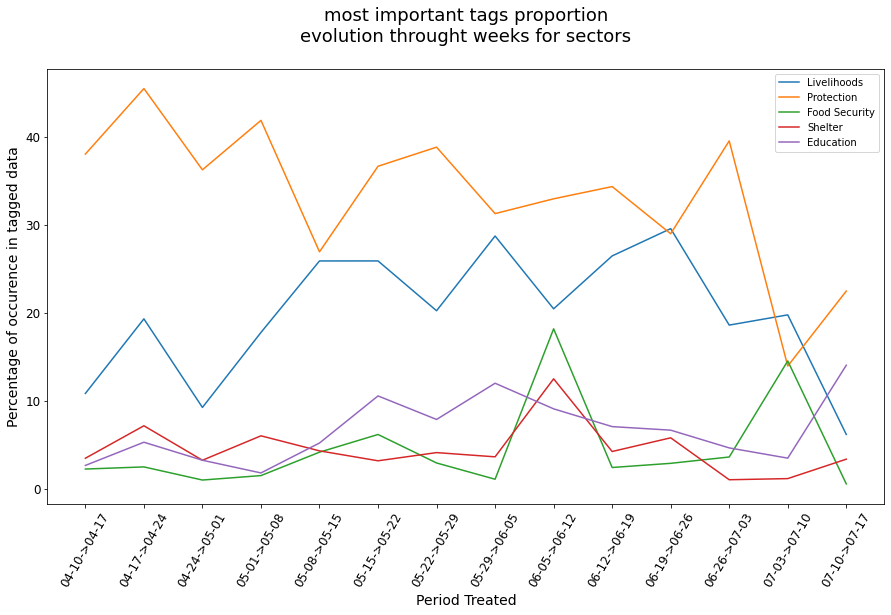

In [18]:
plt.figure(figsize=(15, 8))
for col in ['Livelihoods', 'Protection', 'Food Security', 'Shelter', 'Education']:
    sns.lineplot(data=df_sectors, x='dates', y=col, label=col)
    plt.legend()

plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for sectors\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)

In [21]:
df_subpillars_1d = pd.DataFrame(subpillars_1d).fillna(0)
df_subpillars_1d['dates'] = df_dates

df_subpillars_1d

,Context,Information and communication,Displacement,Shock /Event/Ongoing conditions,Casualties,Flag,Humanitarian Access,COVID-19 Overview,dates
0,26.584867,1.635992,25.153374,0.204499,2.453988,1.022495,0.000000,0.000000,04-10->04-17
1,12.461059,1.246106,17.757009,0.311526,2.180685,1.246106,0.623053,0.000000,04-17->04-24
2,21.250000,3.500000,25.500000,0.000000,2.000000,0.750000,0.250000,0.000000,04-24->05-01
3,20.783133,0.602410,17.469880,0.000000,0.602410,0.000000,0.000000,0.000000,05-01->05-08
4,27.827381,0.297619,17.857143,0.000000,0.595238,2.380952,0.000000,0.297619,05-08->05-15
5,19.521912,0.000000,11.354582,0.000000,1.593625,1.195219,0.000000,0.000000,05-15->05-22
6,14.705882,0.588235,12.117647,0.235294,2.941176,2.470588,0.000000,0.000000,05-22->05-29
7,10.181818,1.818182,9.818182,0.000000,0.000000,1.454545,0.000000,0.000000,05-29->06-05
8,21.590909,0.000000,20.454545,0.000000,0.000000,0.000000,0.000000,0.000000,06-05->06-12
9,11.919192,0.000000,18.787879,0.202020,1.414141,0.808081,0.000000,0.000000,06-12->06-19


Text(0.5, 0, 'Period Treated')

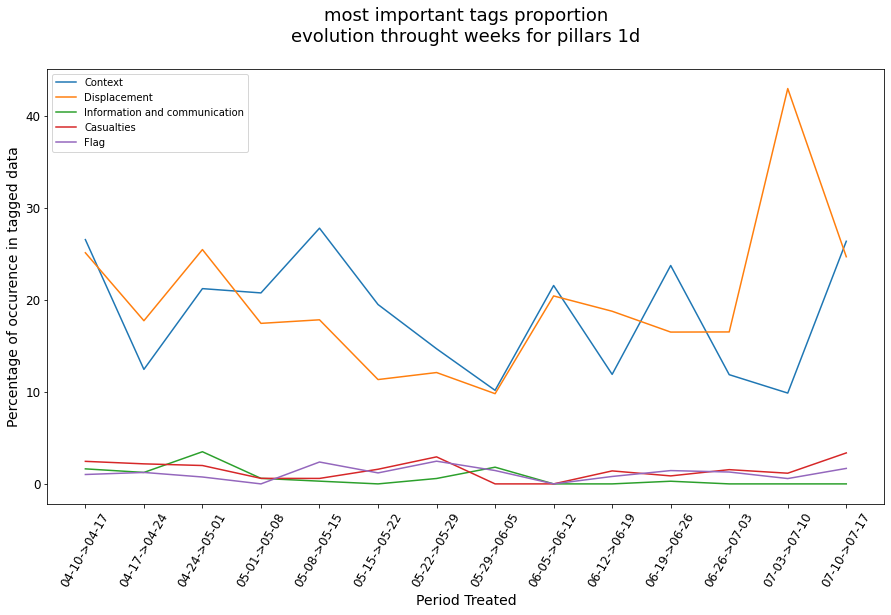

In [22]:
plt.figure(figsize=(15, 8))
for col in ['Context', 'Displacement', 'Information and communication', 'Casualties', 'Flag']:
    sns.lineplot(data=df_subpillars_1d, x='dates', y=col, label=col)
    plt.legend()
    
plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for pillars 1d\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)

In [23]:
df_subpillars_2d = pd.DataFrame(subpillars_2d).fillna(0)
df_subpillars_2d['dates'] = df_dates
df_subpillars_2d

,IMPACT,HUMANITARIAN CONDITIONS,CAPACITIES & RESPONSE,PRIORITIES,AT RISK,dates
0,27.811861,12.474438,19.631902,3.271984,0.408998,04-10->04-17
1,33.021807,18.691589,27.725857,14.953271,0.000000,04-17->04-24
2,32.500000,11.500000,14.500000,13.000000,0.000000,04-24->05-01
3,36.144578,15.963855,15.963855,8.734940,0.000000,05-01->05-08
4,28.273810,19.196429,10.863095,11.160714,0.148810,05-08->05-15
5,36.055777,20.916335,26.693227,12.948207,0.000000,05-15->05-22
6,25.058824,19.647059,30.941176,15.176471,0.000000,05-22->05-29
7,30.909091,35.636364,8.727273,25.090909,0.000000,05-29->06-05
8,39.772727,15.909091,28.409091,6.818182,0.000000,06-05->06-12
9,31.717172,18.585859,20.000000,19.595960,0.000000,06-12->06-19


Text(0.5, 0, 'Period Treated')

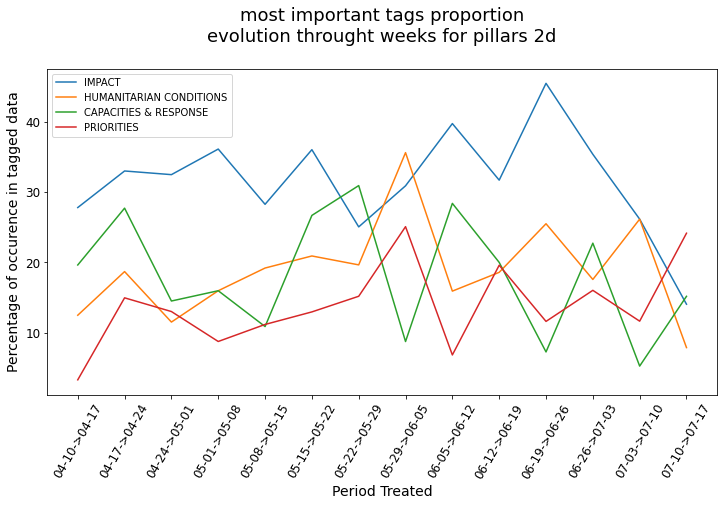

In [24]:
plt.figure(figsize=(12, 6))
for col in ['IMPACT', 'HUMANITARIAN CONDITIONS', 'CAPACITIES & RESPONSE', 'PRIORITIES']:
    sns.lineplot(data=df_subpillars_2d, x='dates', y=col, label=col)
    plt.legend()

plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for pillars 2d\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)

In [25]:
"""df_demographic_groups = pd.DataFrame(demographic_groups).fillna(0)
df_demographic_groups['dates'] = df_dates
df_demographic_groups"""

"df_demographic_groups = pd.DataFrame(demographic_groups).fillna(0)\ndf_demographic_groups['dates'] = df_dates\ndf_demographic_groups"

In [26]:
df_affected_groups = pd.DataFrame(affected_groups).fillna(0)
df_affected_groups['dates'] = df_dates
df_affected_groups

,Displaced,Refugees (international protection),Refugees (temporary protection),Affected,Syrians,Afghans,Iraquis,Others,Migrants,Irregular,Asylum Seekers,Non Displaced,Host,IDP,Regular,Non Host,dates
0,63.599182,21.676892,57.668712,75.460123,46.216769,4.089980,1.022495,2.249489,15.337423,5.725971,3.271984,11.042945,11.042945,0.408998,0.000000,0.000000,04-10->04-17
1,65.732087,34.579439,51.713396,74.766355,33.956386,12.149533,3.738318,2.803738,15.887850,8.099688,7.476636,14.330218,14.330218,1.869159,0.000000,0.000000,04-17->04-24
2,49.250000,23.000000,41.750000,55.250000,31.250000,10.750000,1.000000,3.250000,8.750000,3.500000,2.500000,17.250000,17.250000,0.500000,0.000000,0.000000,04-24->05-01
3,57.831325,30.722892,44.277108,71.987952,26.506024,11.144578,0.903614,2.710843,18.975904,7.228916,5.722892,14.457831,14.457831,0.000000,0.000000,0.000000,05-01->05-08
4,61.607143,26.190476,51.190476,70.535714,38.988095,11.011905,1.636905,1.934524,9.821429,2.529762,4.017857,15.625000,15.625000,0.000000,0.148810,0.000000,05-08->05-15
5,22.509960,12.151394,15.537849,28.087649,10.956175,7.768924,0.000000,0.199203,6.772908,4.780876,1.992032,6.573705,6.573705,0.199203,0.000000,0.199203,05-15->05-22
6,6.941176,4.117647,6.352941,7.058824,3.058824,0.941176,0.352941,0.823529,0.588235,0.000000,0.352941,1.294118,1.294118,0.000000,0.000000,0.000000,05-22->05-29
7,50.545455,35.636364,45.818182,52.363636,20.727273,12.363636,2.909091,8.000000,2.181818,0.000000,3.272727,12.000000,12.000000,0.000000,0.000000,0.000000,05-29->06-05
8,71.590909,17.045455,70.454545,73.863636,59.090909,3.409091,0.000000,0.000000,3.409091,0.000000,0.000000,4.545455,4.545455,0.000000,0.000000,0.000000,06-05->06-12
9,56.565657,18.181818,54.747475,58.585859,37.575758,4.848485,0.808081,0.606061,2.424242,1.010101,2.828283,4.646465,3.636364,0.000000,0.000000,0.000000,06-12->06-19


Text(0.5, 0, 'Period Treated')

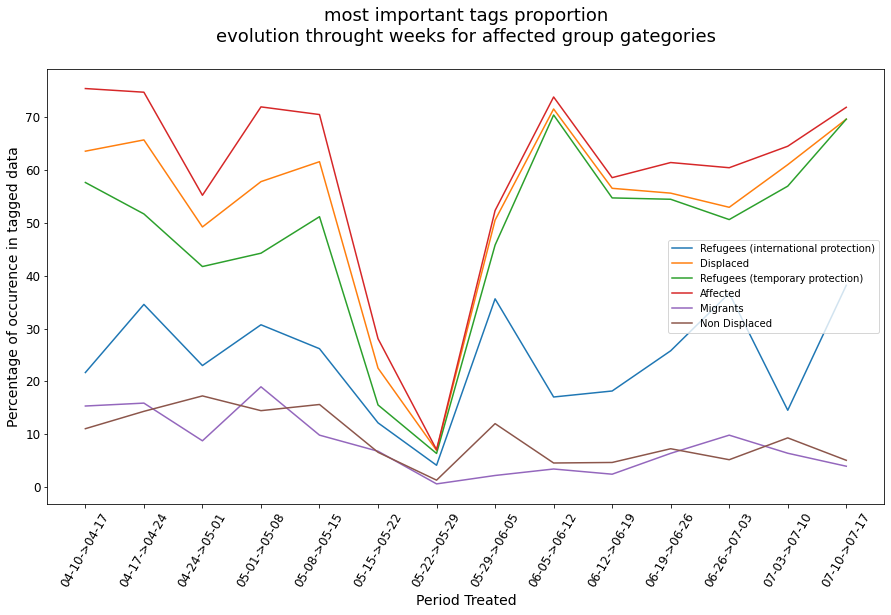

In [28]:
plt.figure(figsize=(15, 8))
for col in [
    "Refugees (international protection)",
    "Displaced",
    "Refugees (temporary protection)",
    "Affected",
    "Migrants",
    "Non Displaced",
]:
    sns.lineplot(data=df_affected_groups, x="dates", y=col, label=col)
    plt.legend()
    
plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for affected group gategories\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)


Text(0.5, 0, 'Period Treated')

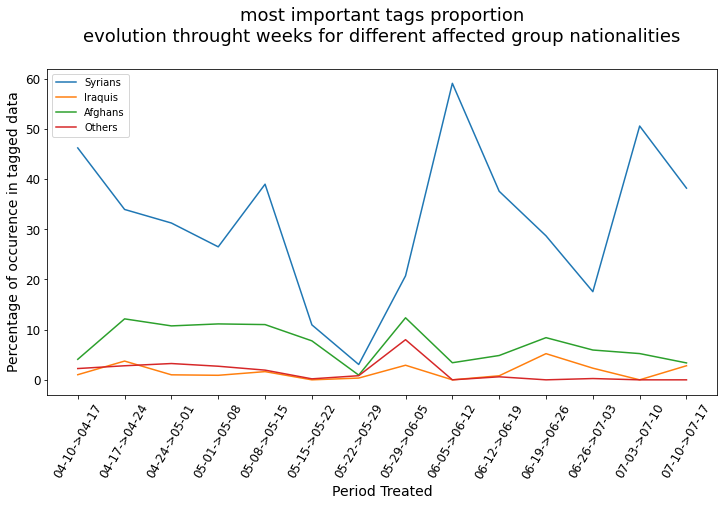

In [29]:
from numpy import size


plt.figure(figsize=(12, 6))
for col in [
    'Syrians', 'Iraquis', 'Afghans', 'Others'
]:
    sns.lineplot(data=df_affected_groups, x="dates", y=col, label=col)
    plt.legend()
plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for different affected group nationalities\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)

In [30]:
df_geo_area = pd.DataFrame(geo_locations).fillna(0)
df_geo_area['dates'] = df_dates
most_important_places = df_geo_area.columns[np.argsort(df_geo_area.mean())[-5:-1]]
most_important_places

Index(['IZMIR', 'GAZIANTEP', 'ANKARA', 'ISTANBUL'], dtype='object')

Text(0.5, 0, 'Period Treated')

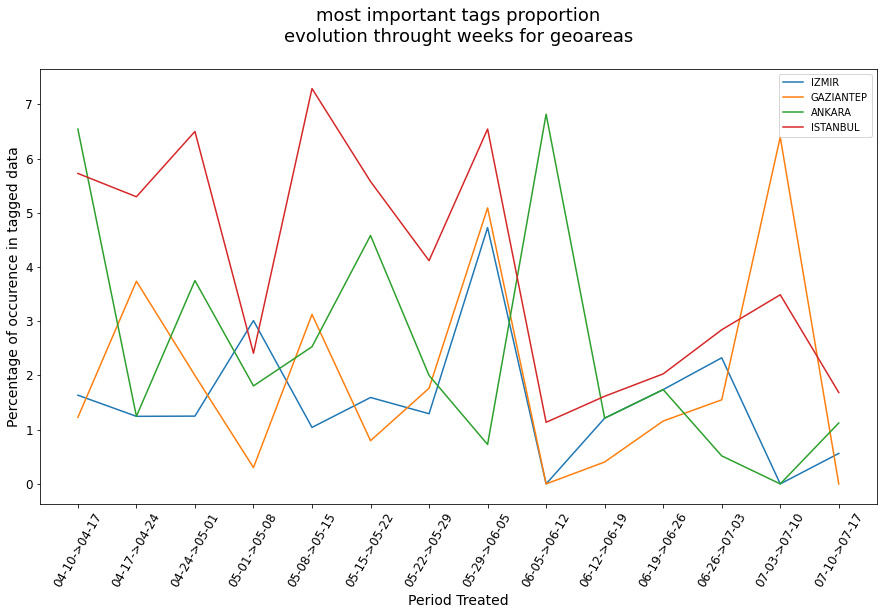

In [31]:
plt.figure(figsize=(15, 8))
for col in most_important_places:
    sns.lineplot(data=df_geo_area, x='dates', y=col, label=col)
    plt.legend()

plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for geoareas\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)

 ## NLP BASED ANALYSIS

In [127]:
turkey_df['excerpt'] = turkey_df['excerpt'].apply(sent_tokenize)
turkey_df = turkey_df.explode('excerpt')

In [128]:
#june_df, july_df_first_week, july_df_second_week

In [139]:
june = turkey_df[turkey_df.created_at.apply(lambda x: x.month==6 and x.year==2022)]
print(june.shape)
june.head(2)

(3352, 16)


,entry_id,created_at,excerpt,sectors,subsectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,geolocation,specific needs groups,demographic groups,affected groups,reliability,severity,subsectors_negative
47,597788,2022-06-27,"7 parties and formations, including the People...",['Cross'],[],['PRIORITIES'],['PRIORITIES->Priority Interventions (Staff)'],['Context'],['Context->Politics'],[528574],[],[],"['Affected', 'Displaced', 'Refugees (temporary...",[],[],False
47,597788,2022-06-27,"The Workers' Party of Turkey (TİP), the Labour...",['Cross'],[],['PRIORITIES'],['PRIORITIES->Priority Interventions (Staff)'],['Context'],['Context->Politics'],[528574],[],[],"['Affected', 'Displaced', 'Refugees (temporary...",[],[],False


In [130]:
july_df_first_week = turkey_df[turkey_df.created_at.apply(lambda x: x.day<10 and x.month==7 and x.year==2022)]
print(july_df_first_week.shape)
july_df_first_week.head(2)

(432, 16)


,entry_id,created_at,excerpt,sectors,subsectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,geolocation,specific needs groups,demographic groups,affected groups,reliability,severity,subsectors_negative
904,602544,2022-07-05,Turkish forces held 40 irregular migrants in e...,['Protection'],[],['IMPACT'],['IMPACT->Impact on People'],"['Casualties', 'Displacement']","['Casualties->Injured', 'Displacement->Type/Nu...","[529448, 528652, 528574]",[],[],"['Affected', 'Migrants', 'Irregular']",[],[],True
904,602544,2022-07-05,Gendarmerie officers at a checkpoint attempted...,['Protection'],[],['IMPACT'],['IMPACT->Impact on People'],"['Casualties', 'Displacement']","['Casualties->Injured', 'Displacement->Type/Nu...","[529448, 528652, 528574]",[],[],"['Affected', 'Migrants', 'Irregular']",[],[],True


In [131]:
july_df_second_week = turkey_df[turkey_df.created_at.apply(lambda x: x.day>=10 and x.month==7 and x.year==2022)]
print(july_df_second_week.shape)
july_df_second_week.head(2)

(755, 16)


,entry_id,created_at,excerpt,sectors,subsectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,geolocation,specific needs groups,demographic groups,affected groups,reliability,severity,subsectors_negative
10616,605271,2022-07-11,A communiqué by the Interior Ministry further ...,['Protection'],[],['IMPACT'],['IMPACT->Impact on People'],[],[],[528574],[],[],"['Affected', 'Migrants']",[],[],True
10639,605282,2022-07-11,"According to authorities, officers had tried t...","['Protection', 'Protection']",['Protection->Justice and Rule of Law'],"['IMPACT', 'IMPACT']","['IMPACT->Impact on People', 'IMPACT->Impact o...",[],[],[528574],[],[],[],[],[],False


* per sector -> subsector: Livelihoods, Protection, Shelter, Education

* per pillars_1d -> subpillars_1d: Context, Displacement

* per pillars_2d -> subpillars_2d: 'IMPACT', 'HUMANITARIAN CONDITIONS', 'CAPACITIES & RESPONSE', 'PRIORITIES'

* per affected group -> Reguees tempoorary/international, syrian, afghans

* specific geolocations -> Not the most common one

In [132]:
from generate_summary import preprocesss_row, get_summary_one_part, get_severity_score, get_reliability_score, get_numbers_score

In [140]:
july_df_first_week.to_csv('Turkey_fist_analysis/july_df_first_week.csv', index=None)
july_df_second_week.to_csv('Turkey_fist_analysis/july_df_second_week.csv', index=None)
june.to_csv('Turkey_fist_analysis/june.csv', index=None)

In [ ]:
#assertion not to run this cell on local
assert(1==2)

# this cell is run on colab
import json

data = {'july_second_week': july_df_second_week, 'june': june, 'july_first_week': july_df_first_week}

columns_treated_items = {
    'affected groups': ['Refugees (international protection)', 'Refugees (temporary protection)', 'Syrians', 'Iraquis'],
    'geolocation': ['IZMIR', 'GAZIANTEP', 'ANKARA', 'ISTANBUL'],
    'sectors': ['Protection', 'Livelihoods', 'Shelter', 'Education'],
    'pillars_1d': ['Context', 'Displacement'],
    'pillars_2d': ['IMPACT', 'HUMANITARIAN CONDITIONS', 'CAPACITIES & RESPONSE', 'PRIORITIES'],
}

reports = {}

for report_title, report_df in data.items():
    report_one_df = {}

    # Columns used later for classification
    report_df["severity_scores"] = report_df["severity"].apply(get_severity_score)
    report_df["reliability_scores"] = report_df["reliability"].apply(get_reliability_score)
    report_df['subpillars'] = report_df.apply(
        lambda x: list(set(custom_eval(x['subpillars_1d']) + custom_eval(x['subpillars_2d']))), axis=1
    )
    report_df["present_numbers_score"] = report_df["subpillars"].apply(get_numbers_score)

    for col_name, kept_items in columns_treated_items.items():

        print(f'begin {col_name}')

        report_df[col_name] = report_df[col_name].apply(
            lambda x: list(set([item for item in custom_eval(x) if item in kept_items]))
        )

        report_df[col_name] = report_df[col_name].apply(
            lambda x: preprocesss_row(x, 1)
        )

        report_one_df[col_name] = get_summary_one_part(
            report_df, col_name, True
        )

    reports[report_title] = report_one_df

with open(f"Turkey_first_analysis_data/full_report.json", "w") as fp:
    json.dump(reports, fp)

## Generate report

In [4]:
from utils import update_outputs_list, omit_punctuation, order_dict, update_df

In [5]:
with open("Turkey_first_analysis_data/full_report.json") as f:
    generated_data = f.read()

generated_data = literal_eval(generated_data)

In [13]:
generated_data = {
    period_name: generated_data[period_name]
    for period_name in ["june", "july_first_week", "july_second_week"]
}


In [24]:
final_report = ""
final_raw_outputs = ""

used_entries_df = pd.DataFrame()
for one_period_name, generated_data_one_period in generated_data.items():
    final_report, final_raw_outputs = update_outputs_list(
            final_report, final_raw_outputs, str(r"\newpage")
        )

    final_report, final_raw_outputs = update_outputs_list(
            final_report, final_raw_outputs, str("\n \section{" + one_period_name + "}\n")
        )

    one_period_df = pd.DataFrame()

    for subsection_name, generated_data_one_subsection in test_data.items():
        final_report, final_raw_outputs = update_outputs_list(
            final_report, final_raw_outputs, str("\subsection{" + subsection_name + "}\n")
        )

        for tag, generated_entries_one_tag in order_dict(generated_data_one_subsection).items():

            final_report, final_raw_outputs = update_outputs_list(
                final_report,
                final_raw_outputs,
                str("\paragraph{" + omit_punctuation(tag) + "}\n"),
            )

            try:
                clean_generated_entries_one_tag = literal_eval(generated_entries_one_tag)
            except Exception as e:
                clean_generated_entries_one_tag = generated_entries_one_tag

            final_report, final_raw_outputs = update_outputs_list(
                final_report, final_raw_outputs, clean_generated_entries_one_tag
            )

            paragraph_df = update_df(generated_entries_one_tag)
            paragraph_df["paragraph"] = f"{subsection_name}->{tag}"
            one_period_df = one_period_df.append(paragraph_df)
            
            # final_str += clean_characters(v)
            final_report, final_raw_outputs = update_outputs_list(
                final_report, final_raw_outputs, "\n \n"
            )
    one_period_df['period'] = one_period_name

used_entries_df = used_entries_df.append(one_period_df)

final_report = final_report.replace('_', ' ')

In [26]:
#print(final_report)

In [25]:
one_period_df.head(3)

,entry_id,excerpt,paragraph
0,602640,"Among those deported, Afghanistan ranks first ...",affected groups->[General Overview]
1,602644,"The citizenship process of 2,000 Uyghur Turks ...",affected groups->[General Overview]
2,601321,"As of May, a total of 648 participants pursued...",affected groups->[General Overview]
